# Audio Classification with Freesound

In [1]:
import numpy as np # for linear algebra
import shutil
import os
from scipy.fftpack import fft
from scipy import signal # used to create the STFT Spectogram
from scipy.io import wavfile
import librosa
from sklearn.model_selection import StratifiedKFold # Spitting data into folds
import pandas as pd # for data processing input/output

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
%matplotlib inline
plt.style.use('ggplot')

import IPython.display as ipd # for displaying sound in notebook
from tqdm import tqdm_notebook
import wave

In [32]:
train = pd.read_csv("train_post_competition.csv", usecols=['fname', 'label', 'manually_verified'])
test = pd.read_csv("test_post_competition.csv", usecols=['fname', 'label'])

In [3]:
print(train.shape[0], "training examples.")
print(len(train.label.unique()), "unique classes")
train.head()

9473 training examples.
41 unique classes


fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

In [4]:
print(test.shape[0], "test examples")
test.head()

1600 test examples


fname      label
0  00326aa9.wav       Oboe
1  0038a046.wav  Bass_drum
2  007759c4.wav  Saxophone
3  008afd93.wav  Saxophone
4  00ae03f6.wav      Chime

In [5]:
# categories should be equally distributed or resampling will be nessisary

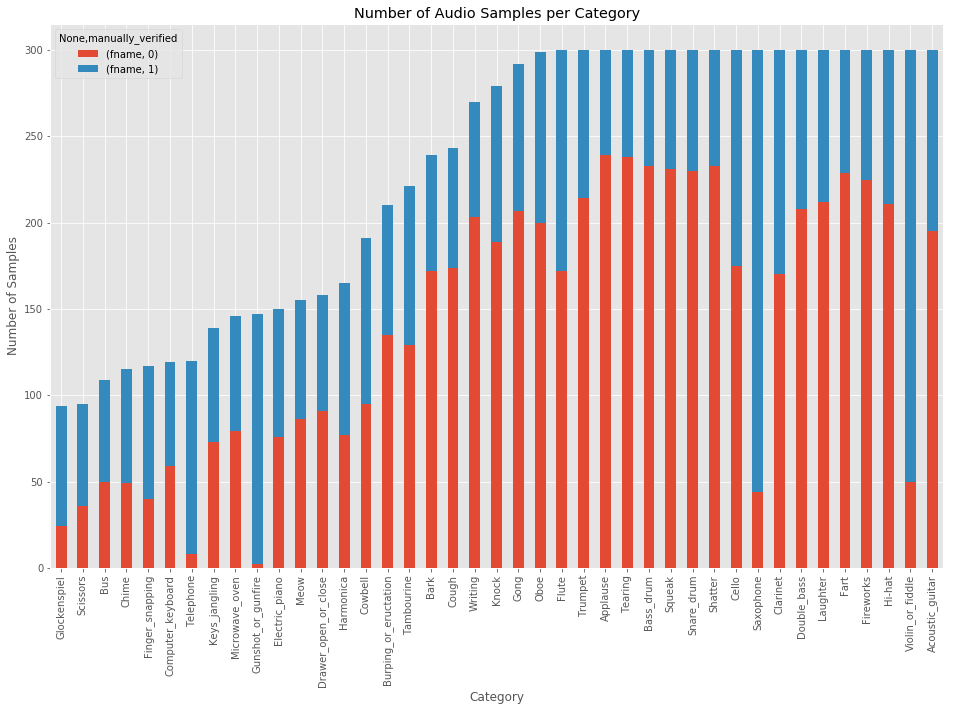

In [6]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [7]:
print(f"max samples in a catergory {max(train.label.value_counts())}")
print(f"min samples in a category {min(train.label.value_counts())}")

max samples in a catergory 300
min samples in a category 94


Data is non-uniform.

## Listening to Some Clips
if we take a listen with Ipython.display and the wav library we can infer some more qualitiatve properties about our dataset.

In [8]:
INPUT_LIB = 'C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\Audio\\Classification\\Audio_Tagging\\input'
TRAIN_LIB = INPUT_LIB + '\\audio_train\\'
fname = TRAIN_LIB + '00ad7068.wav'
fname

'C:\\Users\\Mark\\Documents\\DataSci\\Module 5\\Audio\\Classification\\Audio_Tagging\\input\\audio_train\\00ad7068.wav'

In [9]:
#nice laugh
ipd.Audio(fname)

In [10]:
laugh = fname

In [11]:
#gross cough
fname = TRAIN_LIB + '00d1fe46.wav'
ipd.Audio(fname)

In [12]:
cough = fname

In [13]:
wav = wave.open(laugh)
print(f"Sampling rate {wav.getframerate()}")
print(f'Total samples {wav.getnframes()}')
print(f'duration of laugh {wav.getnframes()/wav.getframerate()}')

Sampling rate 44100
Total samples 191394
duration of laugh 4.34


In [17]:
bit_depth = 16 #the amplitude of each sample is one of 2*16 values
sampling_rate = 44100 #Hz per second of audio. if a clip is 4.3 seconds long it will consisst of 44100*4.3 values 

In [18]:
from scipy.io import wavfile

rate, data = wavfile.read(cough)
print('Sampling rate', rate)
print('Total samples', data.shape)
print(data)

Sampling rate 44100
Total samples (197568,)
[ 2  2  1 ...  0 -2  0]


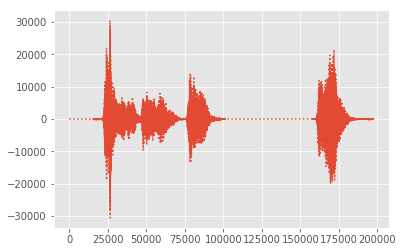

In [19]:
plt.plot( data, ':');

## Cleaning Data
In order to more easily understand our data, joining some of the explored features to the first dataframe might help.  This way we can look for outliers and null values without manually reading each file.

In [ ]:
def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if fname[:2] == '__' :
        file_name = string + file_name
    return file_name

def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == sampling_rate
    return b

In [ ]:
TRAIN_LIB = TRAIN_LIB
TEST_LIB = INPUT_LIB + '\\audio_test\\'
TEST_LIB

In [22]:
train_data = pd.DataFrame({'file_name' : train['fname'],
                          'target' : train['label']})
train_data['time_series'] = train_data['file_name'].apply(load_wav_file, path=TRAIN_LIB)
train_data['nframes'] = train_data['time_series'].apply(len)

In [23]:
test_data = pd.DataFrame({'file_name' : test['fname'],
                          'target' : test['label']})
test_data['time_series'] = test_data['file_name'].apply(load_wav_file, path=TEST_LIB)
test_data['nframes'] = test_data['time_series'].apply(len)

In [24]:
train_data.head()

file_name        target  \
0  00044347.wav        Hi-hat   
1  001ca53d.wav     Saxophone   
2  002d256b.wav       Trumpet   
3  0033e230.wav  Glockenspiel   
4  00353774.wav         Cello   

                                         time_series  nframes  
0  [0, 26, -5, -12, -8, -16, -30, -9, 3, 17, 67, ...   617400  
1  [-33, -32, -34, -34, -37, -37, -39, -39, -41, ...   455112  
2  [0, 0, -2, -1, -1, -2, 0, 0, -1, -1, -1, 1, -1...    19404  
3  [0, 10, 39, -66, -49, 29, 4, -57, -133, -158, ...   352800  
4  [-173, -162, -172, -142, -170, -139, -139, -13...   199332

In [25]:
fname = TRAIN_LIB + str(train_data['file_name'][4])
cello = fname
ipd.Audio(cello)

In [26]:
print(f'Cello plays an #F for {int(train_data.nframes[4])/44100} seconds')

Cello plays an #F for 4.52 seconds


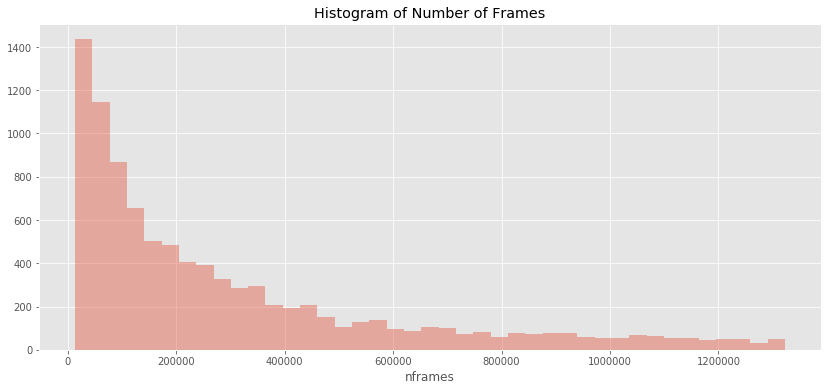

In [27]:
plt.figure(figsize=(14,6))
sns.distplot(train_data.nframes.values, kde=False)
plt.xlabel('nframes')
plt.title('Histogram of Number of Frames')
plt.show();

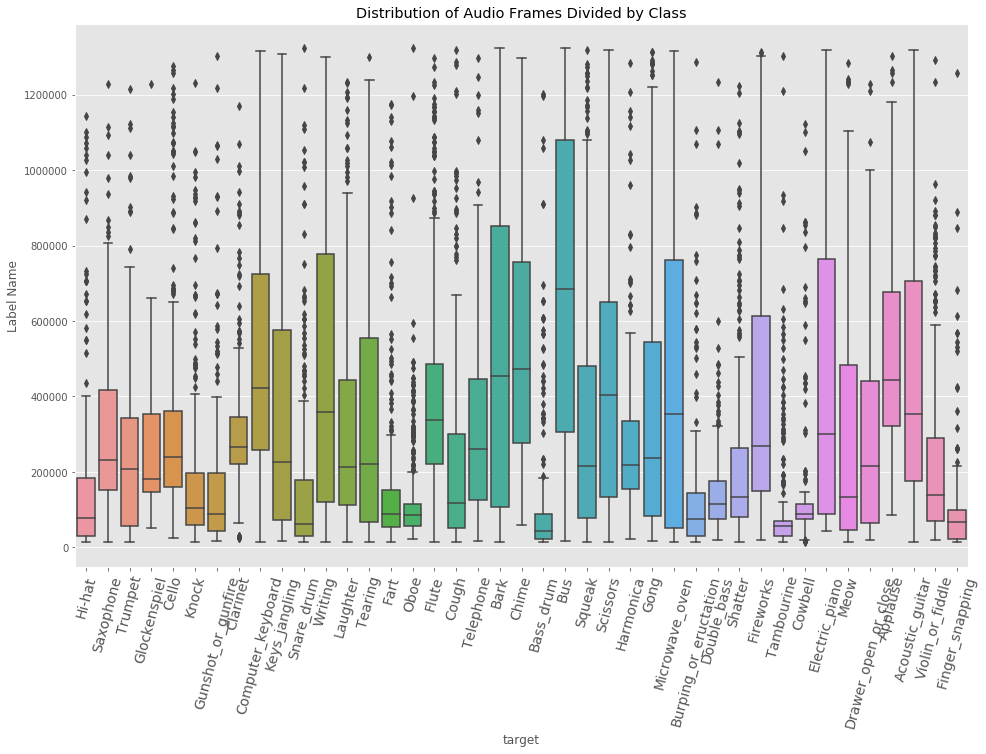

In [28]:
ax = plt.figure(figsize=(16, 10))
sns.boxplot(x="target", y="nframes", data=train_data)
plt.xticks(rotation=75, fontsize=14)
plt.ylabel('Label Name')
plt.title('Distribution of Audio Frames Divided by Class')
plt.show();

Looks like the categories of sounds are non-uniform in time.  Also, the variance is high.
Next, let's have a further look at some outliers.

In [29]:
categories = train_data.sort_values(by='target')
categories.head()

file_name           target  \
1828  3289db4d.wav  Acoustic_guitar   
5240  8dfd2855.wav  Acoustic_guitar   
3254  578874df.wav  Acoustic_guitar   
2473  43a920c9.wav  Acoustic_guitar   
303   08a68ba1.wav  Acoustic_guitar   

                                            time_series  nframes  
1828  [121, 119, 117, 116, 114, 111, 107, 103, 99, 9...  1275372  
5240  [1, -2, -3, -2, -1, 1, 0, 0, -1, -1, -1, 0, 0,...   707364  
3254  [45, 66, 71, 69, 64, 72, 80, 88, 88, 85, 85, 8...  1170414  
2473  [78, 81, 85, 83, 80, 79, 71, 67, 68, 65, 64, 6...   934038  
303   [9, 29, 30, -25, -68, -66, -63, -94, -94, -71,...    16758

In [30]:
instruments = {}
for k in categories.target.unique():
    instruments.update({k:categories[categories.target == k].reset_index()})
#     instrument.update( {k:categories[categories.target == k].reset_index()})

In [31]:
instruments.keys()

dict_keys(['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Burping_or_eructation', 'Bus', 'Cello', 'Chime', 'Clarinet', 'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass', 'Drawer_open_or_close', 'Electric_piano', 'Fart', 'Finger_snapping', 'Fireworks', 'Flute', 'Glockenspiel', 'Gong', 'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 'Keys_jangling', 'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone', 'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine', 'Tearing', 'Telephone', 'Trumpet', 'Violin_or_fiddle', 'Writing'])

Electric_piano : 


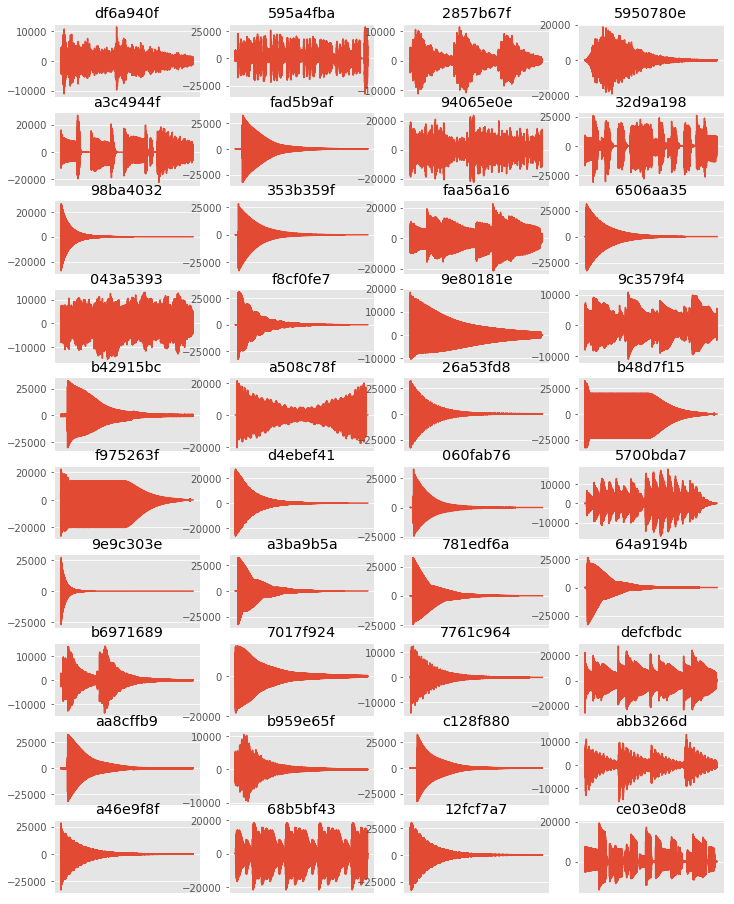

In [32]:
print("Electric_piano : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(instruments['Electric_piano']['time_series'][i])
    ax[i//4, i%4].set_title(instruments['Electric_piano']['file_name'][i][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform", dpi=900) 

Violin_or_fiddle : 


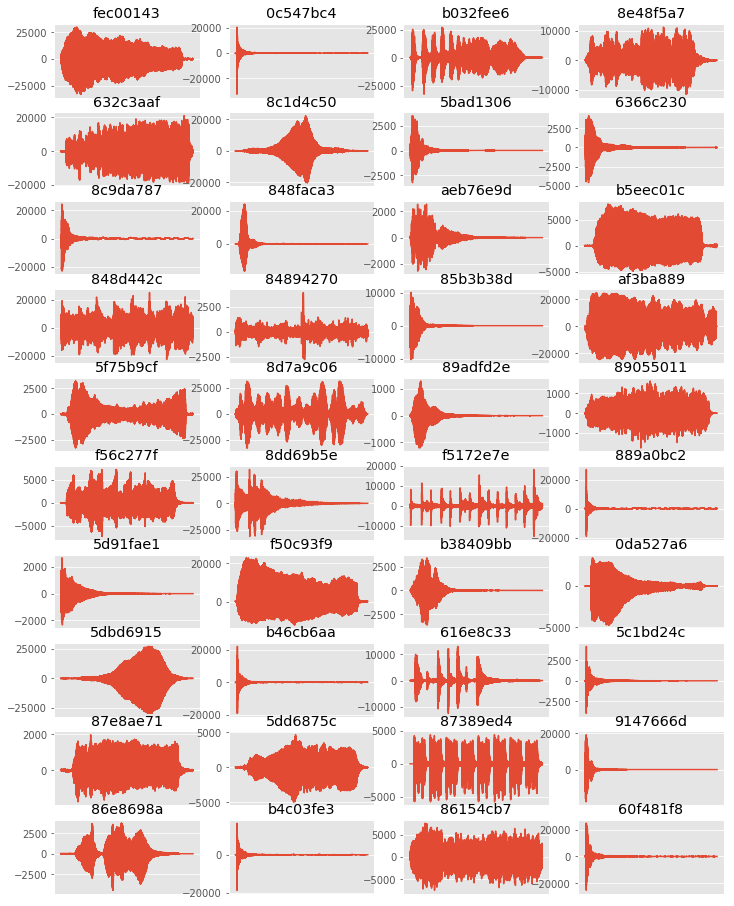

In [33]:
print("Violin_or_fiddle : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(instruments['Violin_or_fiddle']['time_series'][i])
    ax[i//4, i%4].set_title(instruments['Violin_or_fiddle']['file_name'][i][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform", dpi=900) 

Cello : 


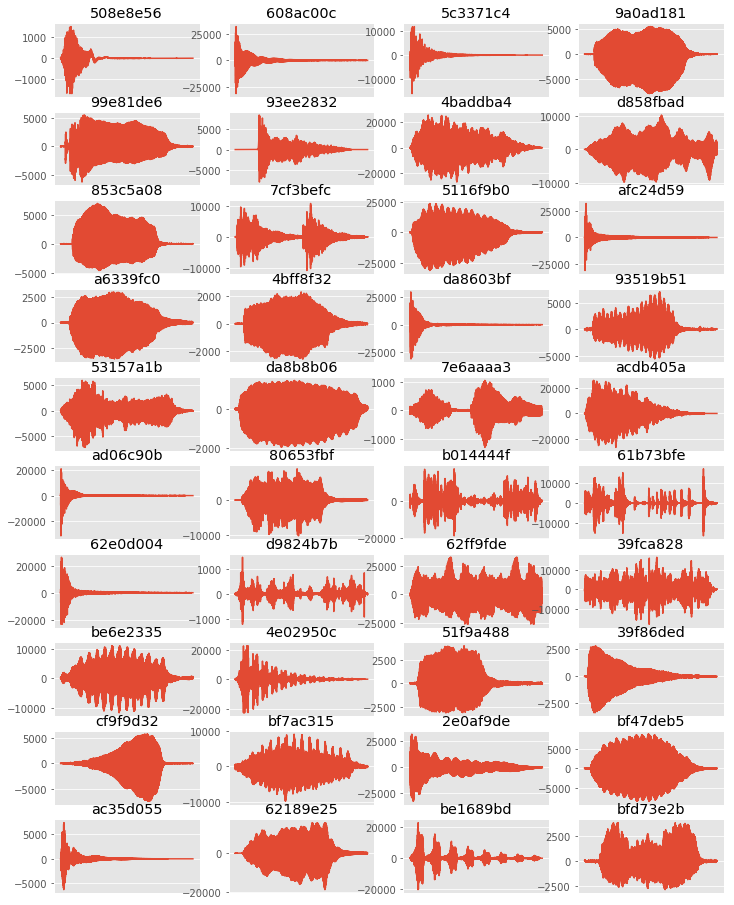

In [34]:
print("Cello : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(instruments['Cello']['time_series'][i])
    ax[i//4, i%4].set_title(instruments['Cello']['file_name'][i][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform", dpi=900) 

### Sound Transformation
#### The Short Time Fourier Transformation

Using the STFT we can essentially condese the signal down into 
Using the Discrete Fourier Transform, Euler's identity and windowing to create frames of the samples
zero padding is ideal to combat spectral leakage

Text(0.5, 0, 'Seconds')

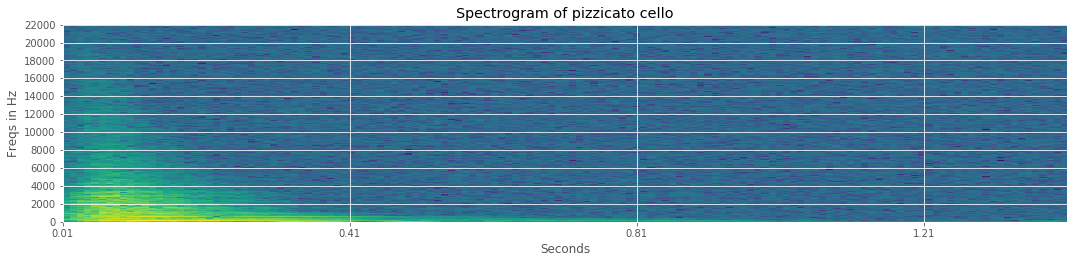

In [14]:
def log_spectogram(sample_rate, audio, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


sample_rate, audio = wavfile.read(TRAIN_LIB +"508e8e56.wav")
freqs, times, spectrogram = log_spectogram(sample_rate, audio)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of pizzicato cello')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Building a Raw Wave Model

The first of two models.
Will take raw audio (1D array) as input and feed data through a Conv1D layer.

The second model will take MFCC in addition and use a Conv2D layer.

In [15]:
from keras import losses, models, optimizers, Sequential
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate, Flatten)
from keras.utils import Sequence, to_categorical

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning:

h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems

Using TensorFlow backend.


In [42]:


# Setup variables
input_length = 44100*10 # First 10 seconds for classification
n_classes = train['label'].unique().shape[0]

# Create model
model = Sequential()
model.add(Convolution1D(filters=4, kernel_size=16, activation='relu', padding='same', input_shape=(input_length, 1)))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=6, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=9, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=14, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=21, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=31, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Convolution1D(filters=46, kernel_size=16, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=5))
model.add(Dropout(rate=0.1))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=n_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 441000, 4)         68        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 88200, 4)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 88200, 4)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 88200, 6)          390       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 17640, 6)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 17640, 6)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 17640, 9)          873       
__________

In [44]:


# Map files to label
file_label_dict = {fname:label for fname, label in train[['fname', 'label']].values}

example_file = "508e8e56.wav"
print('File Label "{}":\n{}'.format(example_file, file_label_dict[example_file]))


# Create vector encoded labels
labelEncoder = {}
for i, label in enumerate(train['label'].unique()):
    label_array = np.zeros(n_classes)
    label_array[i] = 1
    labelEncoder[label] = label_array

example_label = 'Cello'
print('\nEncoded Label "{}":\n{}'.format(example_label, labelEncoder[example_label]))

# Remap predictions to label
prediction_to_label = {np.argmax(array):label for label, array in labelEncoder.items()}



File Label "508e8e56.wav":
Cello

Encoded Label "Cello":
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [48]:


# Define batch generator to yield random data batches
def batchGenerator(files, batch_size):
    # Generate infinite random batches
    while True:
        # Get random files
        batch_files = np.random.choice(files, batch_size, replace=False)

        # Get labels and data
        batch_label = []
        batch_data = []
        # Combine batch
        for file in batch_files:
            # Get label and data
            label = file_label_dict[file]
            rate, data = wavfile.read(TRAIN_LIB+file)
            # Trim data to get uniform length
            data_uniform_length = np.zeros(input_length)
            minimum = min(input_length, data.shape[0])
            data_uniform_length[:minimum] = data[:minimum]
            # Encode label
            encoded_label = labelEncoder[label]
            # Create label and data batch
            batch_label.append(encoded_label)
            batch_data.append(data_uniform_length)
        # Format batches
        batch_label = np.array(batch_label)
        batch_data = np.array(batch_data).reshape(-1, input_length, 1)

        # Batch normalisation
        minimum, maximum = batch_data.min().astype(float), batch_data.max().astype(float)
        batch_data = (batch_data - minimum) / (maximum - minimum)

        # Yield batches for training
        yield batch_data, batch_label



In [86]:
batchGenerator(test_file,1)

<generator object batchGenerator at 0x0000026741EE7200>

In [85]:


# Create random mask to split files in train and validation set
train_val_split_mask  = np.zeros(train.shape[0], dtype=bool)
train_val_split_mask[:8500] = True
np.random.shuffle(train_val_split_mask)

# Get train and validation files
train_files = train['fname'][train_val_split_mask]
val_files = train['fname'][~train_val_split_mask]


# Specify train and validation generators
batch_size = 50
train_generator = batchGenerator(train_files, batch_size=batch_size)
val_generator = batchGenerator(val_files, batch_size=50)

test_file

'00044347.wav'

In [50]:


model.fit_generator(generator=train_generator, validation_data=val_generator, validation_steps=10, epochs=1, steps_per_epoch=train.shape[0]//batch_size)



Epoch 1/2
189/189 [==============================] - 1589s 8s/step - loss: 3.6692 - acc: 0.0294 - val_loss: 3.6705 - val_acc: 0.0340
Epoch 2/2
 31/189 [===>..........................] - ETA: 23:31 - loss: 3.6604 - acc: 0.0329

KeyboardInterrupt: 

Creating a Configuration object is useful for storing global training parameters.  These parameters can be shared between data generators, models, and training functions

In [40]:
class Config(object):
    def __init__(self,
                sampling_rate=16000, audio_duration=2, n_classes=41,
                use_mfcc=False, n_folds=5, learning_rate=0.0001,
                max_epochs=5, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.n_mfcc = n_mfcc
        
        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

Creating a DataGenerator class will be used to feed the data to the Keras model.  The following  class will inherit from keras.utils.Sequence

In [ ]:
class DataGenerator(Sequence): # this structure gaurantees that the network will only train once on each sample per epoch (not the case with generators)
    '''
    initialized with a batch_size
    '''
    def __init__(self, config, data_dir, list_IDs, labels=None,
                batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end() # allows for the user to preform an action at the end of each epoch (shuffle data, increase proportion of augmented data)
        self.dim = self.config.dim
    
    def __len__(self):
        '''
        tells Keras how many batches to drawn in each epoch.
        '''
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        '''
        takes a batch number index and returns the batch of the data (X and y)
        after calculating the offset. During test, only X is returned.
        '''
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[i] for i in indexes]
        return self.__data_generation(list_IDs_temp)
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        
#             
    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))
        
        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                       res_type='kaiser_fast')
            
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                array = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = int(max_offset/2)
                else:
                    offset = 0
                array = np.pad(data, (offset,), mode='constant')
                
            # Normalization and Preprocessing
            if self.config.use_mfcc:
                array = librosa.feature.mfcc(array, sr=self.config.sampling_rate, n_mfcc=self.config.n_mfcc)
                array = np.expand_dims(array, axis=-1)
            else:
                array = self.preprocessing_fn(array)[:, np.newaxis]
            X[i,] = array
            
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [18]:
def audio_norm(data):
    '''
    resacling features to [0,1] for best use in networks
    '''
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

In [19]:
def get_1d_dummy_model(config):
    '''
    For debugging since the final model will no doubt be fairly time consuming.
    '''
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model  

In [20]:
def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [33]:
train.head()

fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

In [42]:
COMPLETE_RUN = True # set to false for debugging

LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
# train.set_index("fname", inplace=True)
# test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])

config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

In [43]:
config.audio_length

32000

In [44]:
train.shape

(9473, 3)

In [37]:
if COMPLETE_RUN:
    model = get_1d_conv_model(config)
else:
    model = get_1d_dummy_model(config)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31992, 16)         160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1997, 32)          1568      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1995, 32)          3104      
__________

In [ ]:
train_dir = os.getcwd() + '\\input\\audio_train\\'
# validation split
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(train.index, train.label_idx, test_size = 0.1)
print(len(X_tr), len(y_tr))
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=config.n_folds)
# skf.get_n_splits(X_tr, y_tr)

for i,(train_index, val_index) in enumerate(skf.split(X_tr, y_tr)):
    train_set = train.iloc[train_index]
    val_set = train.iloc[val_index]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*5)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, train_dir, train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, train_dir, val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)

    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=0, max_queue_size=20)
    
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

8525 8525
Fold:  0
#####
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
data 24000 offset 4000 input length 32000
data 16000 offset 8000 input length 32000
data 7360 offset 12320 input length 32000
data 12800 offset 9600 input length 32000
data 23040 offset 4480 input length 32000
data 6720 offset 12640 input length 32000
data 5120 offset 13440 input length 32000
data 17600 offset 7200 input length 32000
data 18880 offset 6560 input length 32000
data 31360 offset 320 input length 32000
data 17600 offset 7200 input length 32000
data 13120 offset 9440 input length 32000
data 27520 offset 2240 input length 32000
data 12800 offset 9600 input length 32000
data 22400 offset 4800 input length 32000
data 7360 offset 12320 input length 32000
data 21440 offset 5280 input length 32000
data 14400 offset 8800 input length 32000
  1/120 [..............................] - ETA: 27:07 - loss: 3.7137 - acc: 0.0469data 7680 offset 12160 input length 32000
data 211

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\utils\data_utils.py", line 565, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\utils\data_utils.py", line 548, in <lambda>
    initargs=(seqs,))
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\multiprocessing\pool.py", line 175, in __init__
    self._repopulate_pool()
  File "C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\multipro

In [39]:


# for i, (train_split, val_split) in enumerate(skf):
#     train_set = train.iloc[train_split]
#     val_set = train.iloc[val_split]
#     checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
#     early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
#     tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

#     callbacks_list = [checkpoint, early, tb]
#     print("Fold: ", i)
#     print("#"*50)
#     if COMPLETE_RUN:
#         model = get_1d_conv_model(config)
#     else:
#         model = get_1d_dummy_model(config)

#     train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train_set.index, 
#                                     train_set.label_idx, batch_size=64,
#                                     preprocessing_fn=audio_norm)
#     val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', val_set.index, 
#                                   val_set.label_idx, batch_size=64,
#                                   preprocessing_fn=audio_norm)

#     history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
#                                   epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)

#     model.load_weights('best_%d.h5'%i)

#     # Save train predictions
#     train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
#                                     preprocessing_fn=audio_norm)
#     predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
#                                           workers=6, max_queue_size=20, verbose=1)
#     np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

#     # Save test predictions
#     test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
#                                     preprocessing_fn=audio_norm)
#     predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
#                                           workers=6, max_queue_size=20, verbose=1)
#     np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

#     # Make a submission file
#     top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
#     predicted_labels = [' '.join(list(x)) for x in top_3]
#     test['label'] = predicted_labels
#     test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)


## Strength Adaptive Crop

Many sound 
crop has important information at the first few seconds. Some sample has it in the middle of crip. However, due to the nature of recording, it is rare to have important information at th end of sounds. The score drops about 0.03~0.04 when learning only the last few seconds.

Then, We introduce Strength Adaptive Crop. We tried to crop the place where the total of db is high preferentially.

This method is very effective because most samples contain important information in places where the sound is loud.